# **🧪 Элемент 119 — AI в химии от СИБУРа**

## **📌 Суть задачи**
Разработка модели машинного обучения для предсказания липофильности (LogP) органических молекул по их структуре (в формате SMILES).

## **🧠 Что такое LogP?**
**LogP** — это логарифм отношения концентрации вещества между органической и водной фазами. \
Характеризует «любовь» молекулы к органике (липофильность) и важен в химической промышленности, фармацевтике и материаловедении.

$$
\log P = \log_{10} \left( \frac{[C]_{\text{органическая фаза}}}{[C]_{\text{водная фаза}}} \right)
$$

# **Установка библиотек**
Установим все необходимые библиотеки: \
**chemprop** — пакет для машинного обучения, специально разработанный для прогнозирования молекулярных свойств с использованием графовых нейронных сетей (GNN)
- [Github](https://github.com/chemprop/chemprop)
- [Docs](https://chemprop.readthedocs.io/en/latest/)

In [ ]:
! pip install chemprop

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/sibur_ai

Mounted at /content/drive
/content/drive/MyDrive/sibur_ai


# **Импорт библиотек**

При возникновении ошибки ```
ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject``` просто перезагрузите сеанс

In [7]:
# Анализ данных
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm, trange
tqdm.pandas()

# Хемоинформатика
from rdkit import Chem
from rdkit.Chem import AllChem

In [8]:
train = pd.read_csv('train.csv')
train.head()

,ID,SMILES,LogP
0,0,C1(NON=C1C2=CC=CC=C2)=N,3.093
1,1,C=1C=CC=CC=1CC(NC=2C=CC(=CC=2)Br)=O,5.245
2,2,C(C)C1=CC=CS1,4.294
3,3,N1C=CNC1=NC2C(OC)=NC(=NC2Cl)C,2.254
4,4,CC(C)CCO,1.939


In [3]:
from rdkit.Chem import Draw

def plot_molecule(smiles: str, width: int = 400, height: int = 200) -> None:

    '''
    Визуализирует молекулу в 2D (статическое изображение).
    Работает в GitHub Preview.
    '''

    mol = Chem.MolFromSmiles(smiles)

    if mol is None:
        raise ValueError('Неверная SMILES строка')

    img = Draw.MolToImage(mol, size=(width, height))
    display(img)

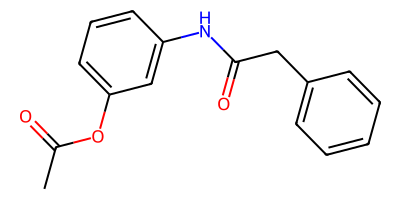

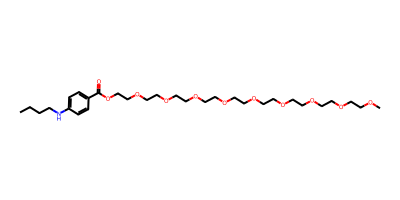

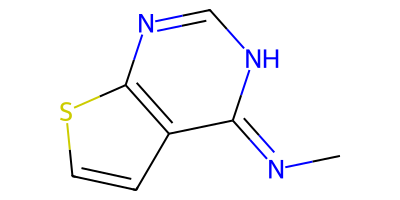

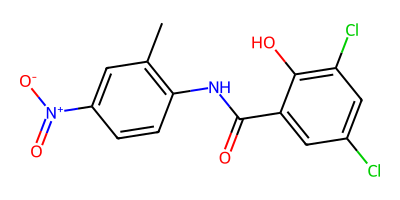

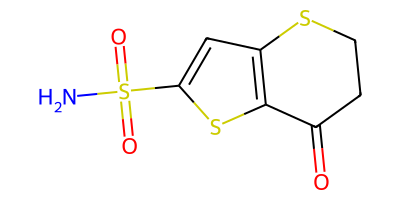

In [9]:
import random

random.seed(42)
random_indices = [random.randint(0, len(train) - 1) for _ in range(5)]

for index in random_indices:
    plot_molecule(train.SMILES[index])

In [ ]:
from rdkit import RDLogger

# Отключаем все предупреждения RDKit
RDLogger.DisableLog('rdApp.*')

In [ ]:
# Фильтрация неправильных молекул
train_clean = train[train['SMILES'].progress_apply(lambda smiles: Chem.MolFromSmiles(smiles) is not None)]

print('Данные очищены')
print(f'Количество первоначальных данных: {len(train)}')
print(f'Осталось данных: {len(train_clean)}')
print(f'Оставлено {len(train_clean) / len(train) * 100:.2f}% данных')

  0%|          | 0/13403 [00:00<?, ?it/s]

Данные очищены
Количество первоначальных данных: 13403
Осталось данных: 12953
Оставлено 96.64% данных


# 📊 **Анализ данных**
Построим распределение характеристики LogP

In [ ]:
from matplotlib import pyplot as plt

def plot_distribution(values) -> None:

    '''
    Строит гистограмму распределения значений LogP

    Параметры:
        values (pd.Series): серия числовых значений LogP

    Функция визуализирует распределение значений LogP
    '''

    plt.figure(figsize=(10, 6))
    ax = values.plot(kind='hist',
                     bins=20,
                     color='skyblue',
                     edgecolor='white',
                     alpha=0.8)

    # Заголовок и подписи
    plt.title('LogP Distribution', fontsize=16, pad=20)
    plt.xlabel('LogP Values', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)

    # Убираем верхнюю и правую границы
    ax.spines[['top', 'right']].set_visible(False)

    # Сетка
    ax.grid(axis='y', linestyle='--', alpha=0.4)

    # Цвет фона
    ax.set_facecolor('#f5f5f5')

    # Размер шкалы
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

    # Добавляем линию среднего значения
    mean_val = values.mean()
    plt.axvline(mean_val, color='salmon', linestyle='--', linewidth=2)
    plt.text(mean_val*1.05, ax.get_ylim()[1]*0.9, f'Mean: {mean_val:.2f}', color='salmon')

    plt.tight_layout()
    plt.show()

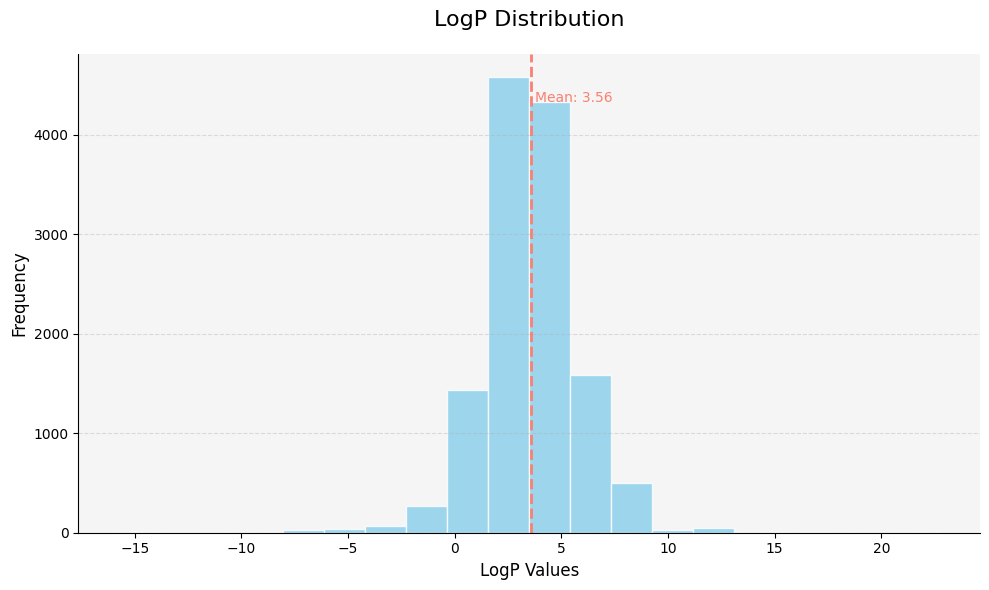

In [ ]:
plot_distribution(train_clean['LogP'])

# **Анализ распределения целевой переменной (LogP)**

На гистограмме видно, что большинство значений LogP сконцентрировано в диапазоне от **-2** до **9**, при этом среднее значение составляет около **3.56**.

## **📌 Почему я выбрал диапазон [-2, 9]:**

- Этот интервал охватывает основную массу данных, исключая редкие выбросы, которые могут негативно повлиять на обучение модели.

- Значения вне этого диапазона (особенно ниже -5 и выше 10) являются редкими и потенциально шумными

In [ ]:
lower_bound = -2
upper_bound = 9

In [ ]:
data_filtered = train_clean[(train_clean['LogP'] > lower_bound) & (train_clean['LogP'] < upper_bound)]

print(f'Количество первоначальных данных: {len(train_clean)}')
print(f'Осталось данных: {len(data_filtered)}')
print(f'Оставлено {len(data_filtered) / len(train_clean) * 100:.2f}% данных')

Количество первоначальных данных: 12953
Осталось данных: 12656
Оставлено 97.71% данных


In [ ]:
# Проверим данные на наличие дубликатов
data_filtered.loc[:, 'SMILES'] = data_filtered['SMILES'].str.strip()
print(f'В данных {data_filtered["SMILES"].duplicated().sum()} дубликатов')

В данных 1864 дубликатов


В исходных данных обнаружено 1864 дубликата по SMILES — это означает, что одни и те же молекулы (с одинаковым описанием структуры) присутствуют в датасете несколько раз с разными значениями LogP.

Чтобы избавиться от дублирования и избежать переобучения модели на одинаковых молекулах, я объединил такие строки и усреднил значения Log

In [ ]:
data_filtered.loc[:, 'SMILES'] = data_filtered['SMILES'].str.strip()
data_filtered = data_filtered.groupby('SMILES').agg({
    'LogP': 'mean',
}).reset_index()

print(f'Осталось данных: {len(data_filtered)}')
print(f'От изначального train осталось {len(data_filtered) / len(train) * 100:.2f}% данных')

Осталось данных: 10792
От изначального train осталось 80.52% данных


Посмотрим на распределение целевой характеристики после фильтрации данных

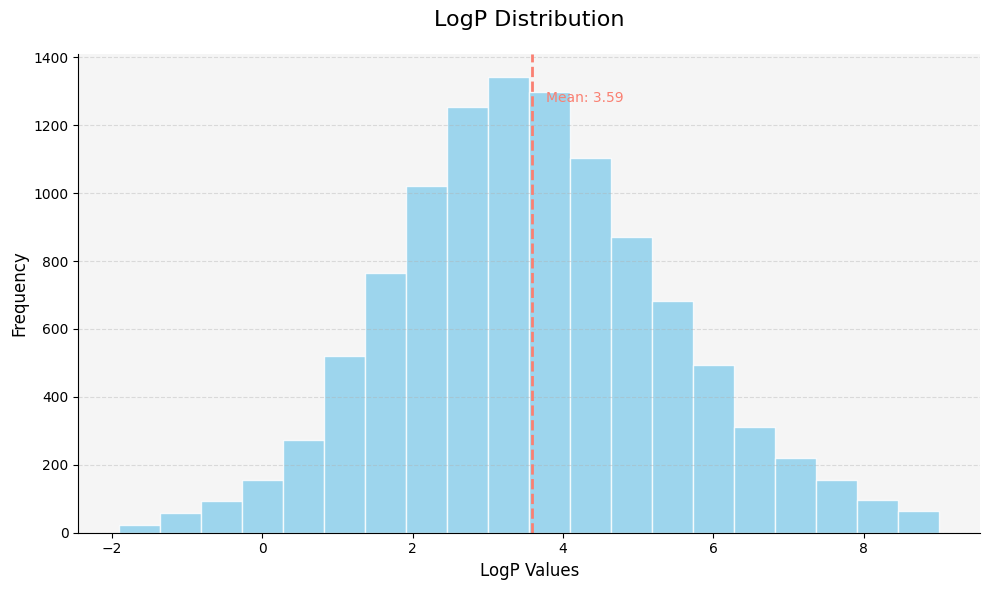

In [ ]:
# Распределение после очистки данных
plot_distribution(data_filtered['LogP'])

In [ ]:
data_filtered.to_csv('train_clean.csv', index=False)

In [ ]:
train = pd.read_csv('train_clean.csv')
print(f'В тренировочных данных {len(train)} строк')

В тренировочных данных 10792 строк


In [ ]:
train.head()

,SMILES,LogP
0,BrC(Br)(Br)Br,4.147
1,BrC(Br)(Br)CO,2.897
2,BrC(Br)(C(N)=O)C#N,1.824
3,BrC(Br)C(NC(C(O)C=1C=CC(=CC=1)[N+](=O)[O-])CO)=O,3.524
4,BrC1=C(C(NC2=NCCN2)=CC=C1)C,3.443


# **Обучение модели**

**Chemprop** — это специализированная библиотека для предсказания химических свойств молекул с использованием графовых нейронных сетей (GNN)

![](https://migalkin.github.io/kgcourse2021/assets/images/l8/l8_mpnn.png)

Она предоставляет мощные инструменты для работы с молекулярными структурами, интегрируя графовые представления молекул и методы машинного обучения \

Наилучшие гиперпараметры была подобраны руками

| **Гиперпараметр**        | **Значение**                         |
|--------------------------|--------------------------------------|
| `epochs`                 | 80                                   |
| `patience`               | 15                                   |
| `message-hidden-dim`     | 800                                  |
| `depth`                  | 5                                    |
| `ffn-hidden-dim`         | 1200                                 |
| `ffn-num-layers`         | 4                                    |
| `dropout`                | 0.2                                  |
| `init-lr`                | 0.0005                               |
| `max-lr`                 | 0.001                                |
| `final-lr`               | 0.00005                              |
| `batch-size`             | 128                                  |
| `split-type`             | `random`                             |
| `ensemble-size`          | 7                                    |
| `num-replicates`         | 7                                    |
| `pytorch-seed`           | 99                                   |

In [ ]:
! chemprop train \
  --data-path "train_clean" \
  --task-type 'regression' \
  --smiles-columns 'SMILES' \
  --target-columns 'LogP' \
  --metric 'rmse' \
  --epochs 80 \
  --patience 15 \
  --message-hidden-dim 800 \
  --depth 5 \
  --ffn-hidden-dim 1200 \
  --ffn-num-layers 4 \
  --dropout 0.2 \
  --init-lr 0.0005 \
  --max-lr 0.001 \
  --final-lr 0.00005 \
  --batch-size 128 \
  --split-type 'random' \
  --ensemble-size 7 \
  --num-replicates 7 \
  --pytorch-seed 99 \
  --save-dir "logp_model"

Получился ансамбль из 49 моделей. График обучения выглядит так
![](https://github.com/droyti46/sibur-element-119/blob/main/img/train-loss.png?raw=true)

Точность предсказания на обучающей выборке
![](https://github.com/droyti46/sibur-element-119/blob/main/img/comparison.jpg?raw=true)

# **Формирование предсказания**

In [ ]:
! chemprop predict \
  --test-path 'test.csv' \
  --model-paths 'logp_model' \
  --smiles-columns 'SMILES' \
  --preds-path 'submission.csv'

In [ ]:
submission = pd.read_csv('submission.csv')
submission.drop(columns=['SMILES']).to_csv('submission.csv', index=False)

# **Готово 🎉**

### **✅ Результаты**

- RMSE на публичной части: **0.57779**
- RMSE на приватной части: **0.66125**

## **🏆 8 место в лидерборде**